# Using the _Herschel_-SPIRE Point Source Catalogue: demo \#1

This simple notebook demonstrates a simple use of the SPIRE Point Source Catalogue (SPSC). The user provides an Observation ID (OBSID) and the script will download the three SPIRE level-2 images for each band 250, 350 and 500 µm (mnemonic names `PSW`, `PMW` and `PLW` respectively) and will overlay the objects from the catalogue and optionally the sources from the initial source table.

**Required python packages:** `python 3.6` and above and the _standard_ `numpy`, `matplotlib` and `astropy`.

In [3]:
import os
import sys
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bmh')

%matplotlib inline

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
from astropy.nddata import Cutout2D

sys.path.append(os.getcwd())
from getSpirePhotMaps import getSpirePhotMaps

In [4]:
spire_bands = ["PSW","PMW","PLW"]
#
obsid = 1342188757
#
# set the Tmp where the archive .tar file will be stored
#
myTmp = os.path.join(os.path.expanduser('~'),"Tmp","HerschelData")
#
# download the maps, hmaps will be a dictionary of FITS HDUs with keys "PSW", "PMW" and "PLW"
#
hmaps = getSpirePhotMaps(obsid,tmpDir=myTmp)
target = hmaps['PSW'][0].header['OBJECT']

Found an already existing tar file for OBSID 1342188757. Will use it


In [5]:
#
# now read the catalogue and sources
#
cats_dir = '/Volumes/WORK/Works/herspire/SPIRE_PSC_v3/cats'
cat = {}
src = {}
for band in spire_bands:
    cat[band] = Table.read(f'{cats_dir}/{obsid}_{band}_catalog_sources.csv')
    src[band] = Table.read(f'{cats_dir}/{obsid}_{band}_sources.csv')
#

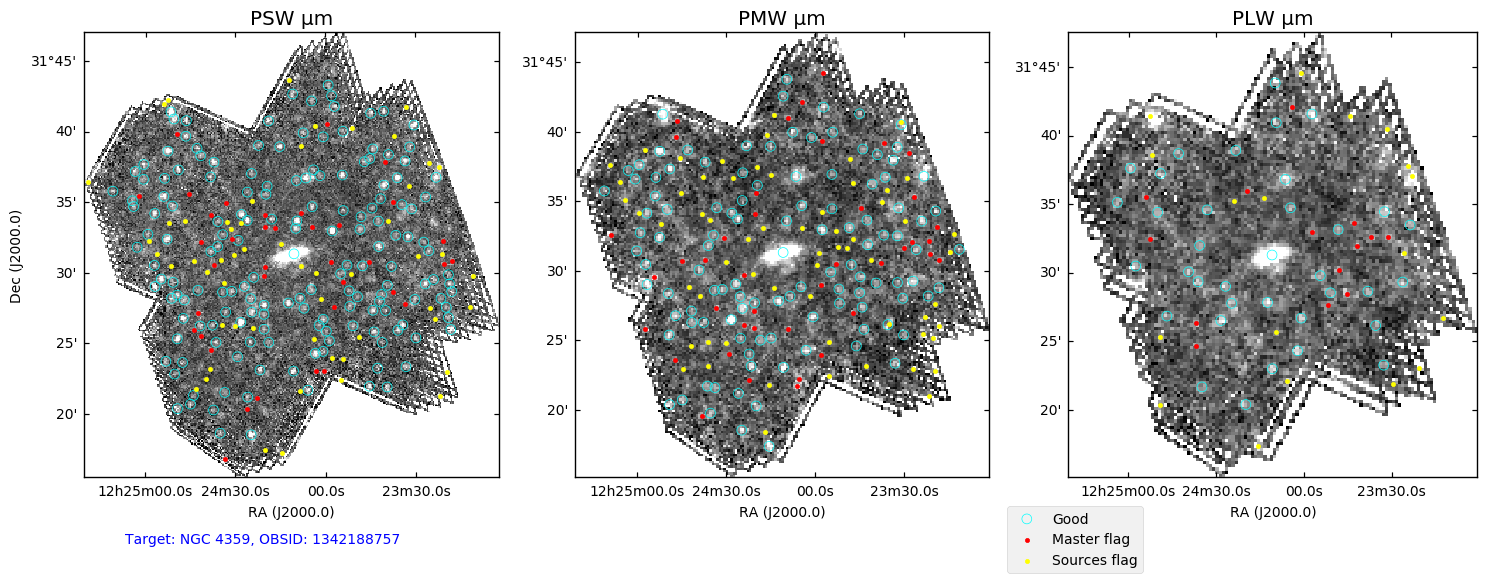

In [6]:
#
# plot the maps and the sources
#
#
fig = plt.figure(figsize=(15,5),dpi=100)
pp = 98.0 # 
for k,band in enumerate(spire_bands):
    wcs = WCS(hmaps[band]['image'].header)
    ax = fig.add_subplot(1,3,k+1,projection=wcs)
    ax.set_title(f'{band} µm')
    lon = ax.coords['ra']
    lon.set_axislabel('RA (J2000.0)')
    lon.set_major_formatter('hh:mm:ss.s')
    lat = ax.coords['dec']
    if (k == 0):
        lat.set_axislabel('Dec (J2000.0)')
    else:
        lat.set_axislabel('')
    lat.set_major_formatter('dd:mm')    
    ximage = hmaps[band]['image']
    norm = ImageNormalize(ximage.data[~np.isnan(ximage.data)], interval=PercentileInterval(pp))
    ax.imshow(ximage.data,norm=norm,cmap=plt.cm.gray,origin='lower',interpolation='nearest')
    #
    # now plot the catalog and sources
    #
    rax = cat[band]['ra']
    decx = cat[band]['dec']
    igood = np.where(cat[band]['master'] == 't')[0]
    ibad = np.where(cat[band]['master'] == 'f')[0]
    #
    # the sources
    #
    raz = src[band]['ra']
    decz = src[band]['dec']
    iz = np.where(src[band]['master'] == 'f')[0]
    #
    ax.scatter(rax[igood], decx[igood], transform=ax.get_transform('world'), 
               s=50,edgecolor='cyan', facecolor='none', label='Good')
    ax.scatter(rax[ibad], decx[ibad], transform=ax.get_transform('world'), 
               marker='.', c='red', label='Master flag')
    ax.scatter(raz[iz], decz[iz], transform=ax.get_transform('world'), 
               marker='.', c='yellow', label='Sources flag')
    if (k == 0):
        ax.text(0.1,-0.15,f'Target: {target}, OBSID: {obsid}',transform=ax.transAxes,color='b')
plt.tight_layout(pad=2)
plt.legend(bbox_to_anchor=(0.2, -0.05))
lgnd.legendHandles[0]._sizes = [50];